<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [112]:
#imports

import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import spacy
from spacy.tokenizer import Tokenizer

import requests

#gensim LDA imports
import os
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [113]:
import pandas as pd

# changing to "df"
df = pd.read_json('./data/review_sample.json', lines=True)

In [114]:
df.head(1)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [115]:
#tokenize the yelp reviews
reviews = df['text']

In [116]:
#cleaning with regular expression
#using tokenize function

#def tokenize(text):
#    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
#    tokens = tokens.lower().split()
#    return tokens

#df['tokens'] = reviews.apply(tokenize)

#print("Returning a list of tokens...\n")
#df['tokens'].head()

In [117]:
# with spacy
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(df['text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

df['tokens'] = tokens

df['tokens'].head()

0    [BEWARE!!!, FAKE,, FAKE,, FAKE....We, also, ow...
1    [Came, here, for, lunch, Togo., Service, was, ...
2    [I've, been, to, Vegas, dozens, of, times, and...
3    [We, went, here, on, a, night, where, they, cl...
4    [3.5, to, 4, stars, \n\n, Not, bad, for, the, ...
Name: tokens, dtype: object

In [185]:
#setting up stop words

STOP_WORDS = nlp.Defaults.stop_words.union([' ', 
                                            '\n\n', 
                                            '\n', 
                                            "it's", 
                                            'got', 
                                            '-', 
                                            "don't", 
                                            "i'm", 
                                            "didn't", 
                                            "i've", 
                                            'definitely',
                                            'place',
                                            'it.',
                                            'it'])

tokens = []

for doc in tokenizer.pipe(df['text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)

df['tokens'] = tokens

df['tokens'].head()

0    [beware!!!, fake,, fake,, fake....we, small, b...
1    [came, lunch, togo., service, quick., staff, f...
2    [vegas, dozens, times, stepped, foot, circus, ...
3    [went, night, closed, street, party..., best, ...
4    [3.5, 4, stars, bad, price,, $12.99, lunch,, s...
Name: tokens, dtype: object

In [186]:
# double checking data frame
df.head(1)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,tokens,tokens_string
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w,"[beware!!!, fake,, fake,, fake....we, small, b...","beware!!! fake, fake, fake....we small busines..."


## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [187]:
#df['tokens_string'] = reviews.apply(tokenize)
#applying join to form a single string of the list of tokens
df['tokens_string'] = df['tokens'].apply(lambda x: ' '.join(x))

#vectorize
desc = df['tokens_string']
vect = CountVectorizer()
vect.fit(desc)
dtm = vect.transform(desc)

print(vect.get_feature_names())

['00', '000', '001695', '007', '00a', '00am', '00ish', '00pm', '01', '011802', '02', '02022015', '02pm', '03', '04', '05', '05pm', '06', '07', '08', '09', '0d', '0mph', '10', '100', '1000', '1001', '100k', '100lb', '100s', '100th', '100x', '101', '102', '1026', '1030am', '104', '105', '106', '106lb', '107', '108', '109', '1096', '1099', '10am', '10k', '10min', '10mins', '10news', '10p', '10pm', '10th', '10times', '10x', '10years', '10yrs', '11', '110', '110th', '111', '1115a', '1130', '115', '117', '119', '11a', '11am', '11ish', '11pm', '12', '120', '1200', '1221', '123', '123lbs', '1245p', '125', '1260', '129', '12am', '12k', '12months', '12oz', '12pk', '12pm', '12th', '12か所のコーナーのステアリングさばきは実にお見事でとてもいい体験になりました', '13', '130', '131', '135', '139', '13th', '14', '140', '1400', '14000', '141', '144', '1440', '145', '149', '14oz', '14th', '15', '150', '1500', '150k', '155', '15am', '15ish', '15k', '15min', '15mins', '15pm', '15th', '15をくぐる形', '15を南へ15', '16', '160', '1611', '165', '167', '1

In [188]:
# term frequency feature matrix

data = df['tokens_string']

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf.fit_transform(data)

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,00,000,00pm,07,10,100,1000,101,10pm,11,...,yuck,yuk,yum,yummy,yup,zero,zone,zoo,zucchini,était
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=10, algorithm='kd_tree')

print('Fitting Tfidf vectorized data frame with 10 nearest neighbors...\n')
print(nn.fit(dtm), '\n')

print('Checking first location...\n')
print(nn.kneighbors([dtm.iloc[0].values]), '\n')

print('Checking a query...\n')
print(nn.kneighbors([dtm.iloc[378]]), '\n')

print('Checking tokens up to row 300...\n')
print(data[299][:300], '\n')

random_yelp_review = ['awesome well done great service']

new = tfidf.transform(random_yelp_review)

print('Applying tfidf transform to random review...\n')
print(new, '\n')

dense = nn.kneighbors(new.todense())

print('Applying todense to random review...\n')
print(dense, '\n')

Fitting Tfidf vectorized data frame with 10 nearest neighbors...

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0) 

Checking first location...

(array([[0.        , 1.        , 1.        , 1.24820465, 1.25310905,
        1.26268083, 1.26277203, 1.28420123, 1.28849199, 1.29483145]]), array([[   0, 6311, 6204, 2131, 3276, 6019, 2943, 8470, 5733, 9036]])) 

Checking a query...

(array([[0.        , 1.        , 1.        , 1.22160178, 1.23735936,
        1.25087778, 1.25328669, 1.26384264, 1.26435433, 1.26942759]]), array([[ 378, 6204, 6311, 6450, 4490, 6850, 7890, 1625, 9528, 5331]])) 

Checking tokens up to row 300...

2 houses rent jeff ehlert (broker) saul salcedo (relator) property management me. lied took money owner tenant well. kept telling needed repair house up. care repairs hoa requested do. answer respond tenant 4-5 months. end, owner penalized hoa. pay 10

In [190]:
# top 10 matches
print('1.)\n')
print(data[3044], '\n')
print('2.)\n')
print(data[335], '\n')
print('3.)\n')
print(data[426], '\n')
print('4.)\n')
print(data[6204], '\n')
print('5.)\n')
print(data[6311], '\n')
print('6.)\n')
print(data[1836], '\n')
print('7.)\n')
print(data[9631], '\n')
print('8.)\n')
print(data[3350], '\n')
print('9.)\n')
print(data[1223], '\n')
print('10.)\n')
print(data[1742], '\n')

1.)

love customer service, store clean food great. want tell employees chipotle great work food awesome. challenges vegas restaurants awesome friendly. thank awesome service. 

2.)

love love love. limeade awesome. steak tacos awesome. chicken fajita tacos awesome. awesome awesome awesome! can't wait hit chandler food truck friday again! 

3.)

love music kpop videos awesome! food awesome waiter great personality. 

4.)

旅行でラスベガスに来ましたがネイルがはげてるのが気になり、探したお店でした。 質問にも丁寧に答えてくれましたし、日本人の方も日本語が話せる方も居て、とても綺麗で居心地のいいお店でした。 ネイルはちはるさんと言う綺麗な方が丁寧にしてくれとても気に入りました。 予定になかったまつ毛エクステもお願いし、日本ではまだあまりないブラウンカラーのエクステをしてもらい、とても気に入りました。 また是非マッサージなどで伺いたいと思います。 

5.)

天氣很熱吃不下東西，今天我點了一個韓國冷面湯、餐後點了甜點，冰沙系列不會太甜膩，覺得店家很用心製作，包含擺盤精緻、佐料衛生，夏日想開胃，這是一個不錯的選擇，服務人員也很敬業，以後會常常來 

6.)

great shop great selection!! customer service awesome. mention awesome location ! glad found place! grace style bridal. 

7.)

trips vegas. awesome customer service average food, stars great service. 

8.)

great experience donny wasn't there. food goo

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [125]:
df.head(1)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,tokens,tokens_string
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w,"[beware!!!, fake,, fake,, fake....we, small, b...","beware!!! fake, fake, fake....we small busines..."


In [126]:
df.shape

(10000, 11)

In [127]:
# 80 / 20 train test split
#msk = np.random.rand(len(df)) < 0.8

#train = df[msk]

#test = df[~msk]

#print(len(train))
#print(len(test))

In [128]:
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
rfc = RandomForestClassifier()

pipe = Pipeline([
    ('vect', vect), 
    ('rfc', rfc)
])

In [129]:
parameters = {
    'vect__max_df': (0.6, 0.9),
    'vect__min_df': (.02, .05),
    'vect__max_features': (2000, None),
    'rfc__n_estimators': (100, 250),
    'rfc__max_depth': (15, None)
}

grid_search = GridSearchCV(pipe, parameters, cv=3, n_jobs=4, verbose=1)
grid_search.fit(train['text'], train['stars'])

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:  5.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        no

In [130]:
grid_search.best_params_

{'rfc__max_depth': None,
 'rfc__n_estimators': 100,
 'vect__max_df': 0.6,
 'vect__max_features': 2000,
 'vect__min_df': 0.02}

In [131]:
# prediction on random yelp review from above
pred = grid_search.predict(random_yelp_review)

In [132]:
# predicts a 5 star rating, nice!
print('Passing in the "random_yelp_review" that reads: \n "awesome well done great service" \nreturns a predicted star rating of: ', pred)

Passing in the "random_yelp_review" that reads: 
 "awesome well done great service" 
returns a predicted star rating of:  [5]


## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Keep the `iterations` parameter at or below 5 to reduce run time
    - The `workers` parameter should match the number of physical cores on your machine.
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [191]:
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary

Learn the vocubalary of the yelp data:

In [192]:
from gensim import corpora, models

def get_topic_features(col):
    """Derive topic features from a text pandas series"""
    # generate topics for corpora
    colname = col.name
    col = col.astype(str).apply(lambda x:x.split())
    dictionary = corpora.Dictionary(col)
    corpus = [dictionary.doc2bow(text) for text in col]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    lda = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=100, passes=2, iterations=50)
    lda.print_topics(-1)
    # get topic distribution for doc
    def get_topics(words): return dict(lda[dictionary.doc2bow(words)])
    topics_df = pd.DataFrame(col.apply(get_topics).tolist()).fillna(0.001)
    topics_df.columns = ['topic_'+str(cn)+'_'+colname for cn in topics_df.columns]
    return topics_df

In [193]:
get_topic_features(df['tokens'])

,topic_23_tokens,topic_36_tokens,topic_46_tokens,topic_48_tokens,topic_50_tokens,topic_71_tokens,topic_72_tokens,topic_91_tokens,topic_40_tokens,topic_62_tokens,...,topic_37_tokens,topic_24_tokens,topic_77_tokens,topic_66_tokens,topic_89_tokens,topic_26_tokens,topic_45_tokens,topic_79_tokens,topic_61_tokens,topic_52_tokens
0,0.209577,0.033811,0.107076,0.035720,0.077153,0.314668,0.033695,0.157621,0.001000,0.001000,...,0.001000,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001000
1,0.091945,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.312534,0.084317,0.254098,...,0.001000,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001000
2,0.027063,0.022455,0.001000,0.076185,0.051223,0.001000,0.001000,0.342014,0.001000,0.001000,...,0.001000,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001000
3,0.072073,0.001000,0.074588,0.076595,0.077359,0.150876,0.001000,0.201214,0.001000,0.084018,...,0.001000,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001000
4,0.100618,0.001000,0.001000,0.001000,0.037889,0.001000,0.001000,0.480426,0.001000,0.147963,...,0.001000,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.321058,0.001000,0.001000,0.040706,0.001000,0.082582,0.001000,0.205560,0.069356,0.001000,...,0.001000,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001000
9996,0.001000,0.001000,0.062807,0.001000,0.001000,0.138312,0.001000,0.464975,0.001000,0.015686,...,0.040177,0.001,0.001,0.001,0.001000,0.020416,0.001,0.001,0.001000,0.001000
9997,0.157645,0.001000,0.001000,0.001000,0.001000,0.074789,0.001000,0.340250,0.001000,0.001000,...,0.001000,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001000
9998,0.255263,0.045156,0.038246,0.001000,0.001000,0.051830,0.001000,0.218512,0.001000,0.057239,...,0.037282,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001000


In [194]:
id2word = corpora.Dictionary(df['tokens'])

Create a bag of words representation of the entire corpus

In [195]:
corpus = [id2word.doc2bow(text) for text in df['tokens']]

In [196]:
# check
corpus[78][:10]

[(101, 1),
 (244, 1),
 (337, 1),
 (409, 1),
 (465, 2),
 (476, 1),
 (775, 1),
 (789, 1),
 (1425, 1),
 (1801, 1)]

Your LDA model should be ready for estimation: 

In [209]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   iterations=5,
                   workers=2,
                   num_topics = 20
                  )

In [210]:
lda.print_topics()

[(0,
  '0.007*"good" + 0.007*"great" + 0.005*"food" + 0.005*"service" + 0.005*"time" + 0.005*"like" + 0.003*"came" + 0.003*"went" + 0.003*"little" + 0.003*"love"'),
 (1,
  '0.008*"food" + 0.008*"like" + 0.007*"great" + 0.006*"good" + 0.004*"time" + 0.004*"service" + 0.004*"best" + 0.003*"love" + 0.003*"friendly" + 0.003*"said"'),
 (2,
  '0.006*"great" + 0.006*"food" + 0.006*"good" + 0.005*"like" + 0.004*"time" + 0.004*"service" + 0.003*"nice" + 0.003*"best" + 0.002*"try" + 0.002*"love"'),
 (3,
  '0.007*"food" + 0.005*"like" + 0.005*"time" + 0.004*"good" + 0.004*"service" + 0.004*"great" + 0.003*"came" + 0.003*"best" + 0.003*"come" + 0.003*"nice"'),
 (4,
  '0.008*"great" + 0.006*"food" + 0.006*"service" + 0.005*"like" + 0.005*"good" + 0.004*"time" + 0.003*"ordered" + 0.003*"love" + 0.003*"order" + 0.002*"little"'),
 (5,
  '0.007*"like" + 0.007*"food" + 0.007*"great" + 0.006*"good" + 0.004*"time" + 0.004*"service" + 0.003*"come" + 0.003*"came" + 0.003*"little" + 0.003*"love"'),
 (6,
  '0

In [211]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [212]:
topics = [' '.join(t[0:5]) for t in words]

In [213]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
good great food service time

------ Topic 1 ------
food like great good time

------ Topic 2 ------
great food good like time

------ Topic 3 ------
food like time good service

------ Topic 4 ------
great food service like good

------ Topic 5 ------
like food great good time

------ Topic 6 ------
good like food great service

------ Topic 7 ------
food like good great service

------ Topic 8 ------
food great like good time

------ Topic 9 ------
great like food good service

------ Topic 10 ------
food time service great like

------ Topic 11 ------
like great food good service

------ Topic 12 ------
like good time food great

------ Topic 13 ------
food like good time great

------ Topic 14 ------
good food great time like

------ Topic 15 ------
service food great good like

------ Topic 16 ------
food great like service time

------ Topic 17 ------
great good food time like

------ Topic 18 ------
good food like time service

------ Topic 19 ------
food l

# Topic Model Conclusion

The topic model showed very similar outcomes for the top 20 topics, all showing the same 5 words in a different order. It would be hard to draw any relative conclusion from these topics other than when people leave reviews on yelp, there is a good chance they will be positive in sentiment. 

# Visuals
Create 1-2 visualizations of the results

In [203]:
#visuals

from collections import Counter
word_counts = Counter()
df['tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(15)

[('food', 3687),
 ('great', 3407),
 ('like', 3361),
 ('good', 3235),
 ('service', 2573),
 ('time', 2497),
 ('love', 1597),
 ('best', 1548),
 ('came', 1509),
 ('went', 1445),
 ('ordered', 1438),
 ('come', 1428),
 ('little', 1395),
 ('nice', 1341),
 ('staff', 1272)]

In [204]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [205]:
# using the word counts function to create word counts data frame
wc = count(df['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
458,food,2679,3687,1.0,0.007135,0.007135,0.2679
233,great,2583,3407,2.0,0.006593,0.013729,0.2583
2,like,2409,3361,3.0,0.006504,0.020233,0.2409
208,good,2434,3235,4.0,0.006261,0.026494,0.2434
57,service,2196,2573,5.0,0.004979,0.031473,0.2196


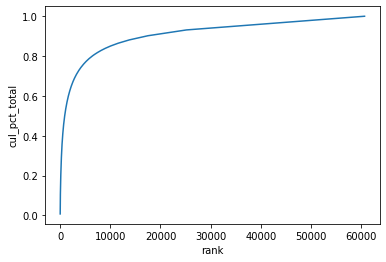

In [206]:
# cumulative distribution plot
import seaborn as sns

sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [207]:
wc[wc['rank'] <= 100]['cul_pct_total'].max()

0.18368571290338195

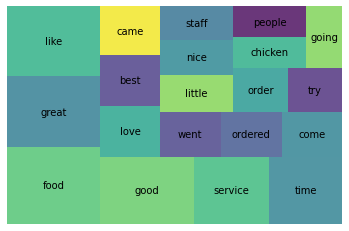

In [208]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)